In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


2024-01-15 15:03:00.972061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 15:03:00.972165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 15:03:01.209516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 15:03:01.911924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 15:03:08.413854: W tensorflow/compiler/tf2

In [2]:
# clear out any old logs
!rm -rf ./logs/ 

In [3]:
SAMPLE_DATA = "data/method_2"

In [4]:
# The audio is all sampled at 44100 and should all be 3 second in length --- IN PROGRESS -----
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be abover the noise floor?
MINIMUM_SIGNAL_LENGTH=EXPECTED_SAMPLES/4

In [5]:
# list of folders we want to process in the method_2 folder
from tensorflow.python.ops import gen_audio_ops as audio_ops
signals = [
    'ringtone',
    'random',
    '_background_noise_',
]

In [6]:
# get all the files in a directory
def get_files(word):
    return gfile.glob(SAMPLE_DATA + '/'+word+'/*.wav')

# get the location of the signal
def get_signal_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)

# Work out how much of the audio file is actually voice
def get_signal_length(audio, noise_floor):
    position = get_signal_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()

# is enough signal present?
def is_signal_present(audio, noise_floor, required_length):
    signal_length = get_signal_length(audio, noise_floor)
    return signal_length >= required_length

# is the audio the correct length?
def is_correct_length(audio, expected_length):
    return (audio>=expected_length)


def is_valid_file(file_name):
    # Load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio_data = audio_tensor.to_tensor()
    audio_numpy = len(audio_data.numpy())

    # check the file is long enough
    if not is_correct_length(audio_numpy, EXPECTED_SAMPLES):
        print("Helo")
        return False
    
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))

    # is there any signal in the audio?
    if not is_signal_present(audio, NOISE_FLOOR, MINIMUM_SIGNAL_LENGTH):
        return False
        
    
    return True

In [7]:
def get_spectrogram(audio):
    # normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))

    # create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    
    # reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    
    spectrogram = tf.squeeze(spectrogram, axis=0)
    spectrogram = np.log10(spectrogram + 1e-6)

    return spectrogram

In [8]:
# process a file into its spectrogram
def process_file(file_path):
    # load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    
    # convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    audio = audio[:EXPECTED_SAMPLES]
    # get the spectrogram
    return get_spectrogram(audio)


In [9]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [10]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label) for file_name in tqdm(file_names, desc=f"{signal} ({label})", leave=False)]

# process the files for a word into the spectrogram and one hot encoding word value
def process_word(signal, repeat=1):
    # the index of the signal signal we are processing
    label = signals.index(signal)
    # get a list of files names for the signal
    
    file_names = [file_name for file_name in tqdm(get_files(signal), desc="Checking", leave=False) if is_valid_file(file_name)]
    print(file_names)
    # randomly shuffle the filenames
    np.random.shuffle(file_names)
    
    # split the files into train, validate and test buckets
    train_size=int(TRAIN_SIZE*len(file_names))
    validation_size=int(VALIDATION_SIZE*len(file_names))
    test_size=int(TEST_SIZE*len(file_names))

    # get the training samples
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # and the validation samples
    validate.extend(
        process_files(
            file_names[train_size:train_size+validation_size],
            label,
            repeat=repeat
        )
    )
    # and the test samples
    test.extend(
        process_files(
            file_names[train_size+validation_size:],
            label,
            repeat=repeat
        )
    )

# process all the signals and all the files
for signal in tqdm(signals, desc="Processing signal"):
    if '_' not in signal:
        # add more examples of marvin to balance our training set
        repeat = 1 if signal == 'ringtone' else 1
        process_word(signal, repeat=repeat)
    
print(len(train), len(test), len(validate))

Processing signal:   0%|          | 0/3 [00:00<?, ?it/s]

Checking:   0%|          | 0/92 [00:00<?, ?it/s]

2024-01-15 15:03:15.204277: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-01-15 15:03:16.214041: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 15:03:16.501442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 15:03:16.501754: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had

['data/method_2/ringtone/NOKIA_5.wav', 'data/method_2/ringtone/NOKIA_5_invert_polarity.wav', 'data/method_2/ringtone/NOKIA_59_pitch_scale.wav', 'data/method_2/ringtone/NOKIA_4.wav', 'data/method_2/ringtone/NOKIA_20_3_L_pitch_scale.wav', 'data/method_2/ringtone/NOKIA_12_invert_polarity.wav', 'data/method_2/ringtone/NOKIA_4_1_add_white_noise.wav', 'data/method_2/ringtone/NOKIA_4_pitch_scale.wav', 'data/method_2/ringtone/NOKIA_45_2_D.wav', 'data/method_2/ringtone/NOKIA_ORIGINAL_3_add_white_noise.wav', 'data/method_2/ringtone/NOKIA_59_add_white_noise.wav', 'data/method_2/ringtone/NOKIA_60_invert_polarity.wav', 'data/method_2/ringtone/NOKIA_ORIGINAL_3_invert_polarity.wav', 'data/method_2/ringtone/NOKIA_5_1_add_white_noise.wav', 'data/method_2/ringtone/NOKIA_4_1_invert_polarity.wav', 'data/method_2/ringtone/NOKIA_45_2_D_add_white_noise.wav', 'data/method_2/ringtone/NOKIA_4_2_add_white_noise.wav', 'data/method_2/ringtone/NOKIA_6.wav', 'data/method_2/ringtone/NOKIA_17.wav', 'data/method_2/ring

ringtone (0):   0%|          | 0/73 [00:00<?, ?it/s]

2024-01-15 15:03:21.237206: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


ringtone (0):   0%|          | 0/9 [00:00<?, ?it/s]

ringtone (0):   0%|          | 0/10 [00:00<?, ?it/s]

Checking:   0%|          | 0/138 [00:00<?, ?it/s]

['data/method_2/random/1-29532-A-16_trimmed.wav', 'data/method_2/random/5-204352-A-13_trimmed.wav', 'data/method_2/random/1-23996-B-35_trimmed.wav', 'data/method_2/random/2-104952-B-16_trimmed.wav', 'data/method_2/random/3-146186-A-44_trimmed.wav', 'data/method_2/random/5-160614-E-48_trimmed.wav', 'data/method_2/random/3-110913-B-7_trimmed.wav', 'data/method_2/random/5-253085-B-3_trimmed.wav', 'data/method_2/random/5-219044-A-46_trimmed.wav', 'data/method_2/random/3-155568-A-32_trimmed.wav', 'data/method_2/random/1-30709-B-23_trimmed.wav', 'data/method_2/random/3-151273-A-35_trimmed.wav', 'data/method_2/random/2-52789-A-4_trimmed.wav', 'data/method_2/random/3-108677-A-18_trimmed.wav', 'data/method_2/random/1-104089-A-22_trimmed.wav', 'data/method_2/random/1-18755-A-4_trimmed.wav', 'data/method_2/random/1-39923-A-1_trimmed.wav', 'data/method_2/random/1-50688-A-17_trimmed.wav', 'data/method_2/random/1-103999-A-30_trimmed.wav', 'data/method_2/random/2-85434-A-27_trimmed.wav', 'data/method

random (1):   0%|          | 0/108 [00:00<?, ?it/s]

random (1):   0%|          | 0/13 [00:00<?, ?it/s]

random (1):   0%|          | 0/15 [00:00<?, ?it/s]

181 25 22


In [11]:
# randomise the training samples
np.random.shuffle(train)

In [12]:
X_train, Y_train = zip(*train)
X_validate, Y_validate = zip(*validate)
X_test, Y_test = zip(*test)


In [13]:
# Save the computed data
np.savez_compressed(
    "training_spectrogram.npz",
    X=X_train, Y=Y_train)
print("Saved training data")
np.savez_compressed(
    "validation_spectrogram.npz",
    X=X_validate, Y=Y_validate)
print("Saved validation data")
np.savez_compressed(
    "test_spectrogram.npz",
    X=X_test, Y=Y_test)
print("Saved test data")

Saved training data
Saved validation data
Saved test data


In [14]:
# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]


In [15]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(5, 5, figsize=(10, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()

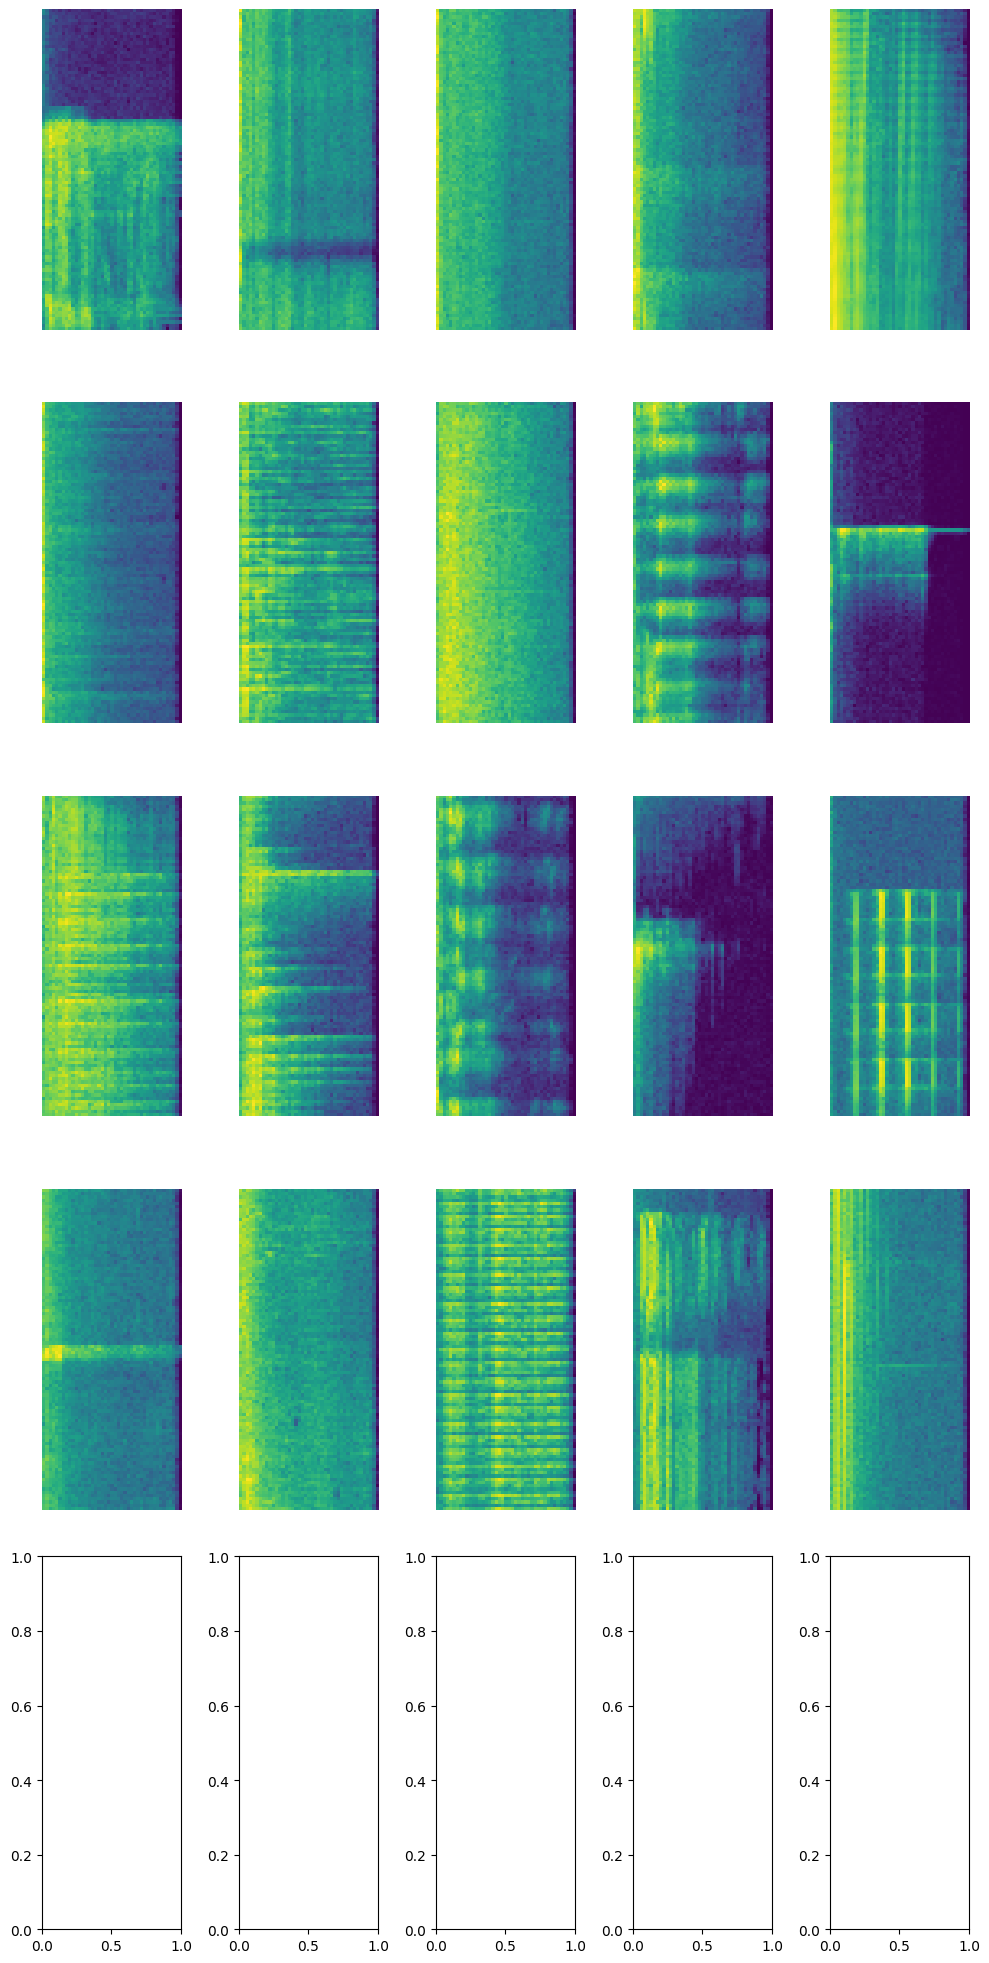

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [16]:
word_index = signals.index("random")

X_rsounds = np.array(X_train)[np.array(Y_train) == word_index]
Y_rsounds = np.array(Y_train)[np.array(Y_train) == word_index]
plot_images2(X_rsounds[:20], IMG_WIDTH, IMG_HEIGHT)
print(Y_rsounds[:20])

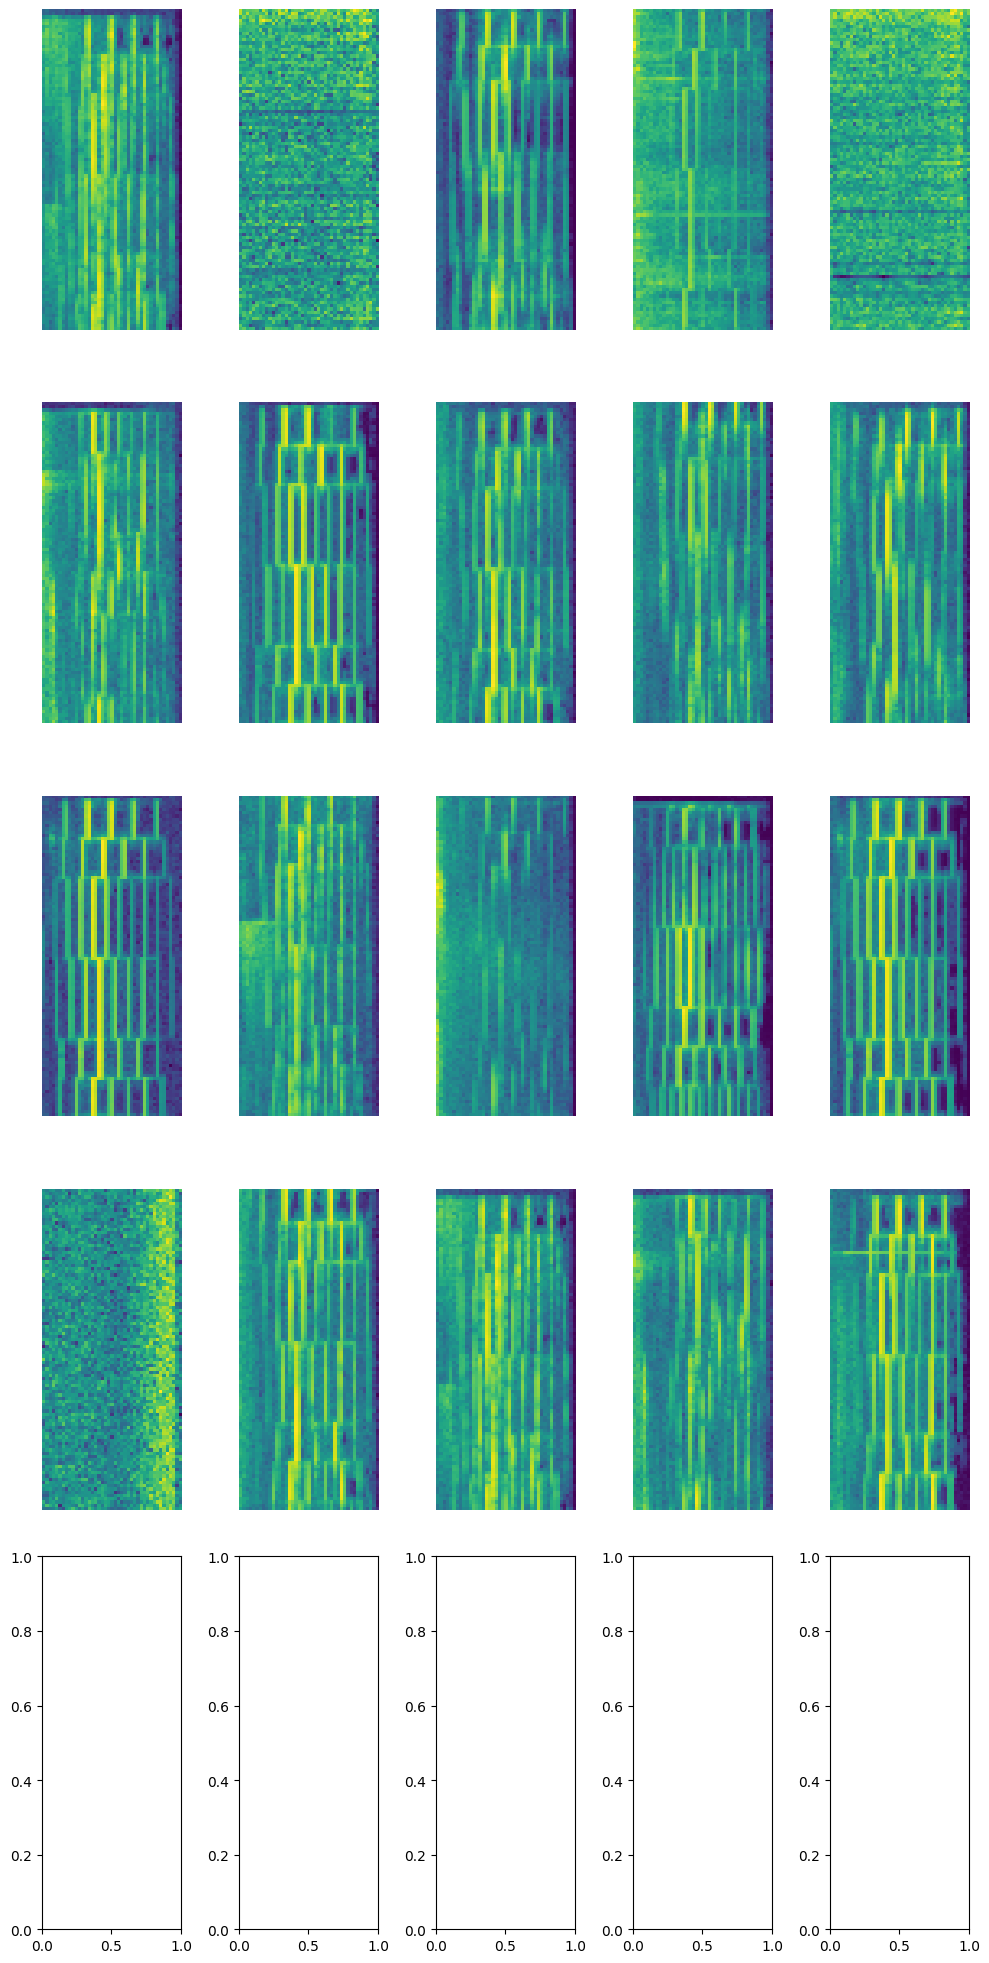

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
word_index = signals.index("ringtone")

X_ringtone = np.array(X_train)[np.array(Y_train) == word_index]
Y_ringtone = np.array(Y_train)[np.array(Y_train) == word_index]
plot_images2(X_ringtone[:20], IMG_WIDTH, IMG_HEIGHT)
print(Y_ringtone[:20])